In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import sys, importlib
from FetchModel import FetchModel
from PostPred import PostPred
importlib.reload(sys.modules['FetchModel'])
importlib.reload(sys.modules['PostPred'])
from FetchModel import FetchModel
from PostPred import PostPred

# 180

In [58]:
Y = pd.read_csv("../Datasets/Dataset_180.csv")
Y['Count_180'] = pd.to_numeric(Y['Count_180']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")

In [59]:
idx_obs = Y[Y['Count_180'].notna()].index
idx_miss = Y[Y['Count_180'].isna()].index

# take XX% of the remaining indexes for a test set
XX = 0.3 # [0, 1] change this value to change the size of the test set
idx_test = sorted(np.random.choice(idx_obs.values, int(XX*len(idx_obs)), replace=False))
idx_miss = sorted(np.concatenate((idx_test, idx_miss.values)))
idx_obs = sorted(np.setdiff1d(idx_obs, idx_test))

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [60]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [61]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [62]:
data_180 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),

    "y": Y_obs['Count_180'],
    "P": X_obs.shape[1],

    "nyears": 13,
    "nstations": 45,
    "nmonths": 7,

    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,

    "X": X_obs,
    "X_miss": X_miss,

    "phi": phi,
    "distances": distances,

    "month": months_obs,
    "month_miss": months_miss
}

In [63]:
bin_logit_var = FetchModel('bin_logit_var').compile()

In [64]:
bin_logit_var_180 = bin_logit_var.sample(data=data_180, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_bin_logit_var_180 = az.from_cmdstanpy(bin_logit_var_180)

23:15:54 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:25:31 - cmdstanpy - INFO - CmdStan done processing.


In [65]:
post_pred = PostPred(posterior_bin_logit_var_180, Y['Count_180'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

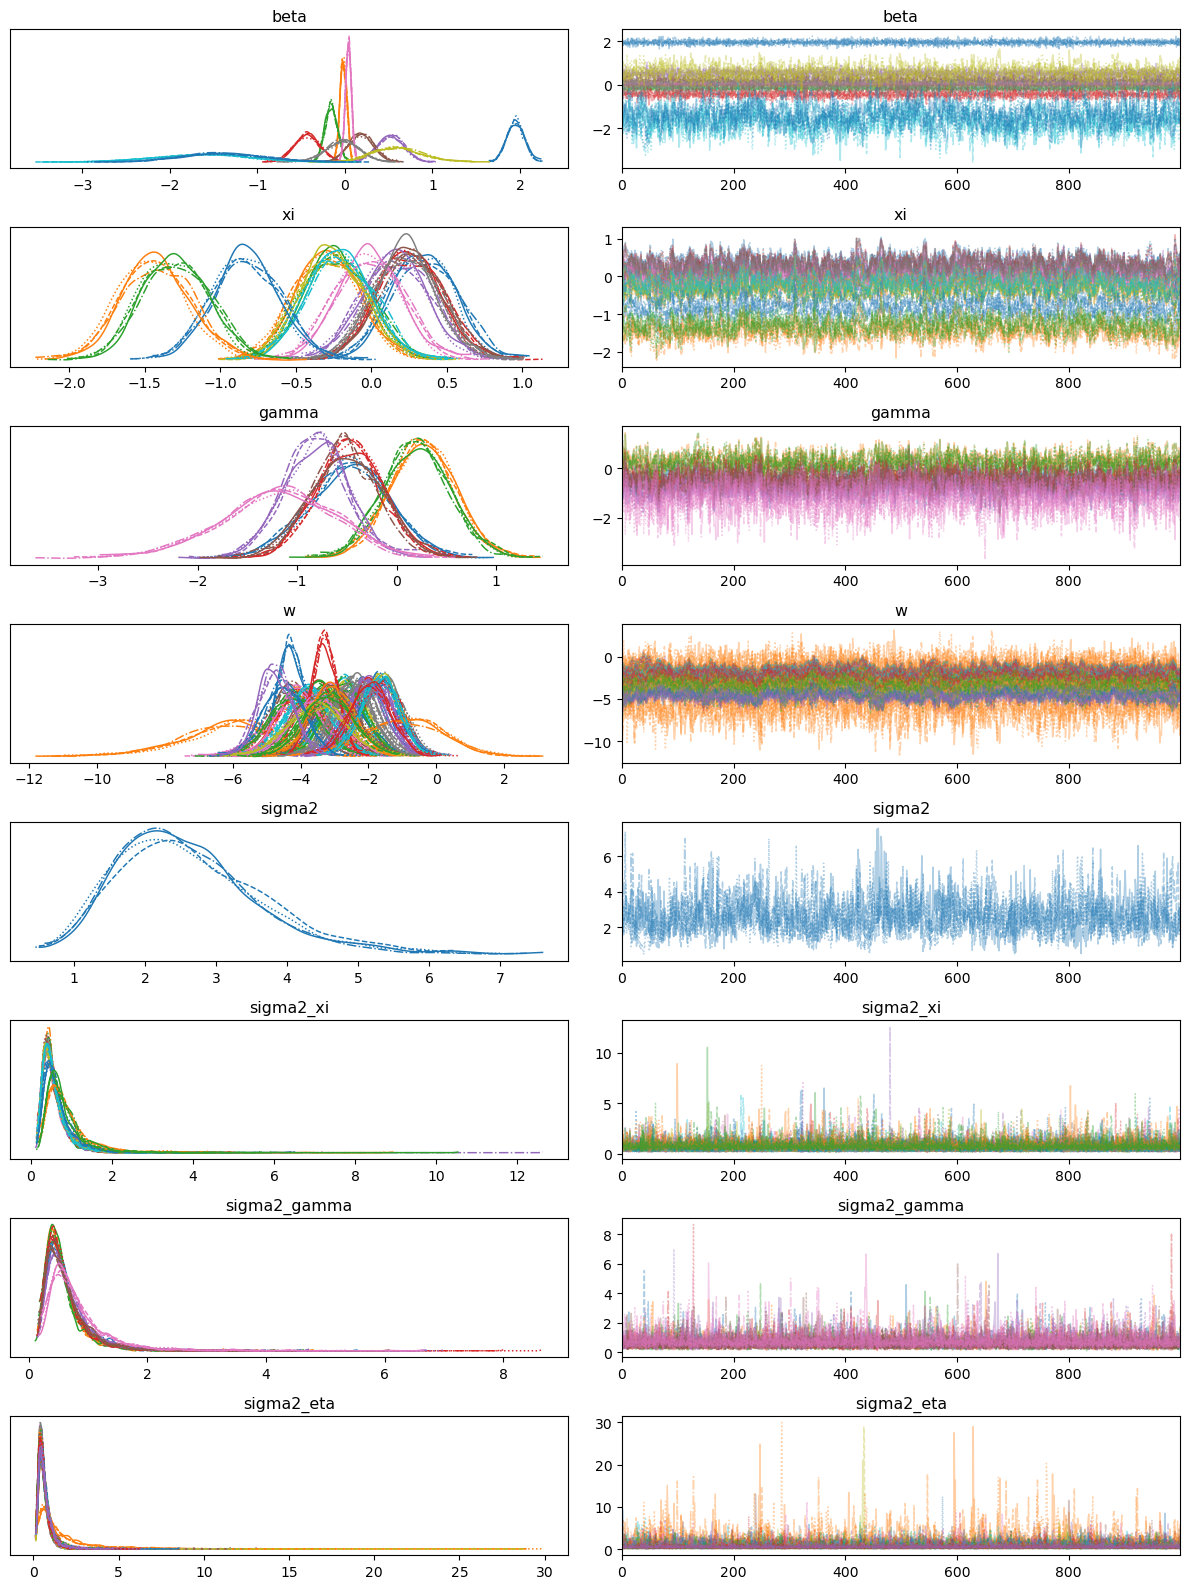

In [66]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'gamma', 'w', 'sigma2', 'sigma2_xi', 'sigma2_gamma', 'sigma2_eta'])
plt.tight_layout()
plt.show()

In [67]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2681.09    75.45
p_waic      124.70        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2681.94    75.49
p_loo      125.55        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2661   99.8%
 (0.5, 0.7]   (ok)          4    0.2%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [68]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [69]:
y_obs, residuals, mse, mae, mad, mse_test, mae_test, mad_test, outliers_test, percentage_inside_CI_test, outliers, percentage_inside = metrics.values()
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The total number of outliers in the test set is: {len(outliers_test)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The MSE in the test set is: {mse_test}\n')
print(f'The MAE in the test set is: {mae_test}\n')
print(f'The MAD in the test set is: {mad_test}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')
print(f'The percentage of observations inside the CI of the test is: {percentage_inside_CI_test}\n')

The total number of outliers is: 135

The total number of outliers in the test set is: 42

The MSE is: 2.0372899159663866

The MAE is: 0.6927521008403361

The MAD is: 0.0

The MSE in the test set is: 2.09369527145359

The MAE in the test set is: 0.6996497373029772

The MAD in the test set is: 0.0

The percentage of observations inside the CI is: 0.9645483193277311

The percentage of observations inside the CI of the test is: 0.9632224168126094



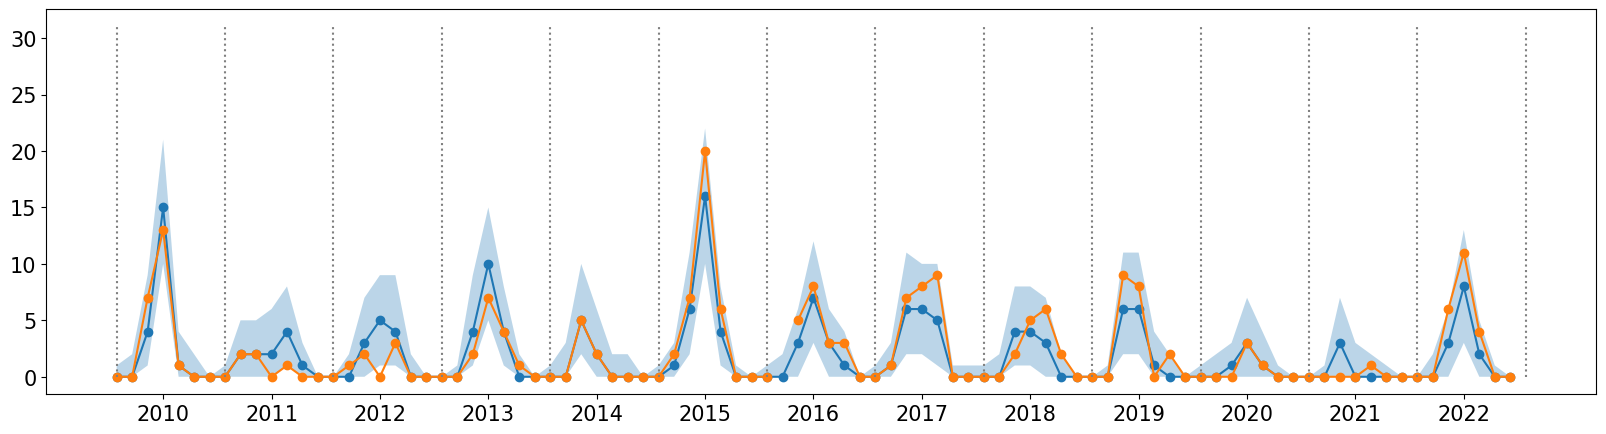

In [70]:
station_num_to_plot = 35 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(13*7*(station_num_to_plot-1), 13*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(20, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted', linestyle='-', marker='o')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed', linestyle='-', marker='o')
plt.xticks(xx[np.arange(3,len(xx),7)], np.arange(2010,2023), fontsize=15)
plt.yticks(fontsize=15)
plt.vlines(xx[np.arange(0,len(xx),7)], ymin=0, ymax=31, colors='gray', linestyles='dotted')
plt.vlines(xx[-1]+1, ymin=0, ymax=31, colors='gray', linestyles='dotted')
plt.savefig('sample_180.pdf')
plt.show()

# 120

In [71]:
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y['Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")

In [72]:
idx_obs = Y[Y['Count_120'].notna()].index
idx_miss = Y[Y['Count_120'].isna()].index

# take XX% of the remaining indexes for a test set
XX = 0.3 # [0, 1] change this value to change the size of the test set
idx_test = sorted(np.random.choice(idx_obs.values, int(XX*len(idx_obs)), replace=False))
idx_miss = sorted(np.concatenate((idx_test, idx_miss.values)))
idx_obs = sorted(np.setdiff1d(idx_obs, idx_test))

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [73]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [74]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [75]:
data_120 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),

    "y": Y_obs['Count_120'],
    "P": X_obs.shape[1],

    "nyears": 13,
    "nstations": 45,
    "nmonths": 7,

    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,

    "X": X_obs,
    "X_miss": X_miss,

    "phi": phi,
    "distances": distances,

    "month": months_obs,
    "month_miss": months_miss
}

In [76]:
bin_logit_var = FetchModel('bin_logit_var').compile()

In [77]:
bin_logit_var_120 = bin_logit_var.sample(data=data_120, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_bin_logit_var_120 = az.from_cmdstanpy(bin_logit_var_120)

23:27:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:38:47 - cmdstanpy - INFO - CmdStan done processing.
23:38:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_logit_var.stan', line 53, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_logit_var.stan', line 53, column 2 to column 63)
Consider re-running with show_console=True if the above output is unclear!


In [78]:
post_pred = PostPred(posterior_bin_logit_var_120, Y['Count_120'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

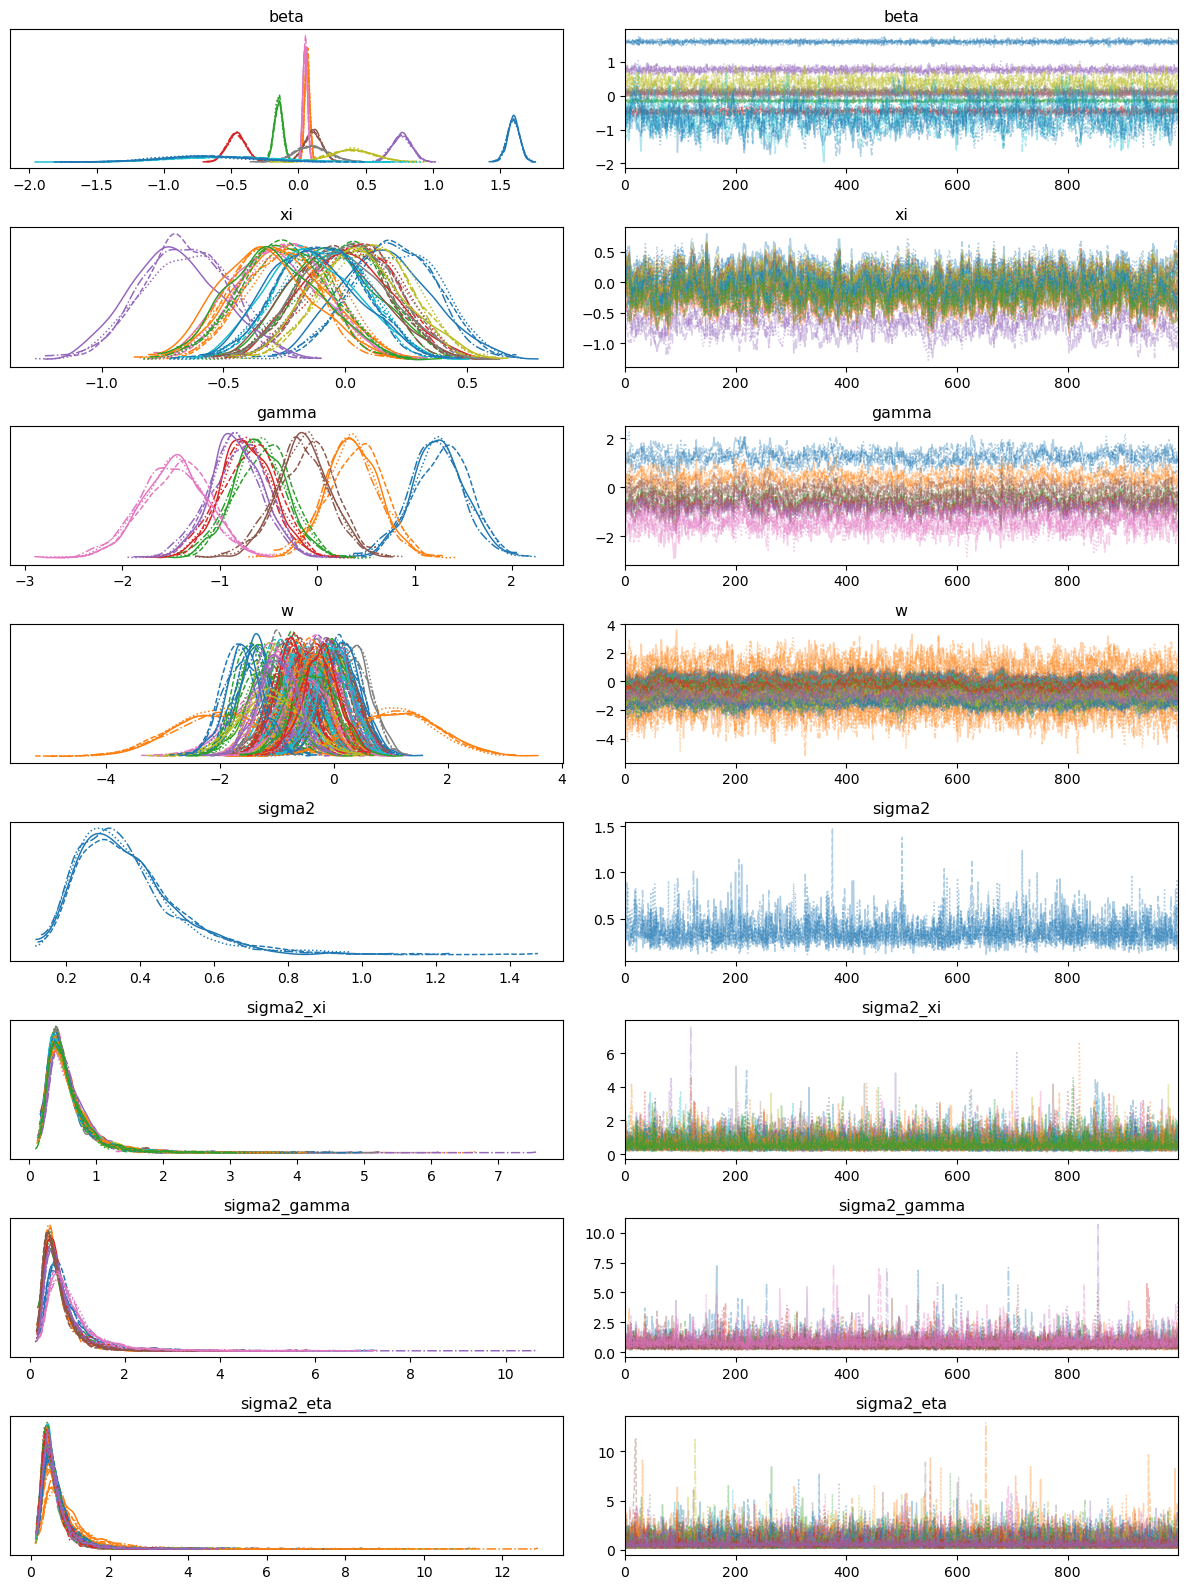

In [79]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'gamma', 'w', 'sigma2', 'sigma2_xi', 'sigma2_gamma', 'sigma2_eta'])
plt.tight_layout()
plt.show()

In [80]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 2688 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -6760.78   103.38
p_waic      162.73        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 2688 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6761.10   103.39
p_loo      163.05        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2687  100.0%
 (0.5, 0.7]   (ok)          1    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [81]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [82]:
y_obs, residuals, mse, mae, mad, mse_test, mae_test, mad_test, outliers_test, percentage_inside_CI_test, outliers, percentage_inside = metrics.values()
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The total number of outliers in the test set is: {len(outliers_test)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The MSE in the test set is: {mse_test}\n')
print(f'The MAE in the test set is: {mae_test}\n')
print(f'The MAD in the test set is: {mad_test}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')
print(f'The percentage of observations inside the CI of the test is: {percentage_inside_CI_test}\n')

The total number of outliers is: 471

The total number of outliers in the test set is: 145

The MSE is: 10.303255208333333

The MAE is: 2.289322916666667

The MAD is: 2.0

The MSE in the test set is: 10.725043402777779

The MAE in the test set is: 2.34765625

The MAD in the test set is: 2.0

The percentage of observations inside the CI is: 0.87734375

The percentage of observations inside the CI of the test is: 0.8741319444444444



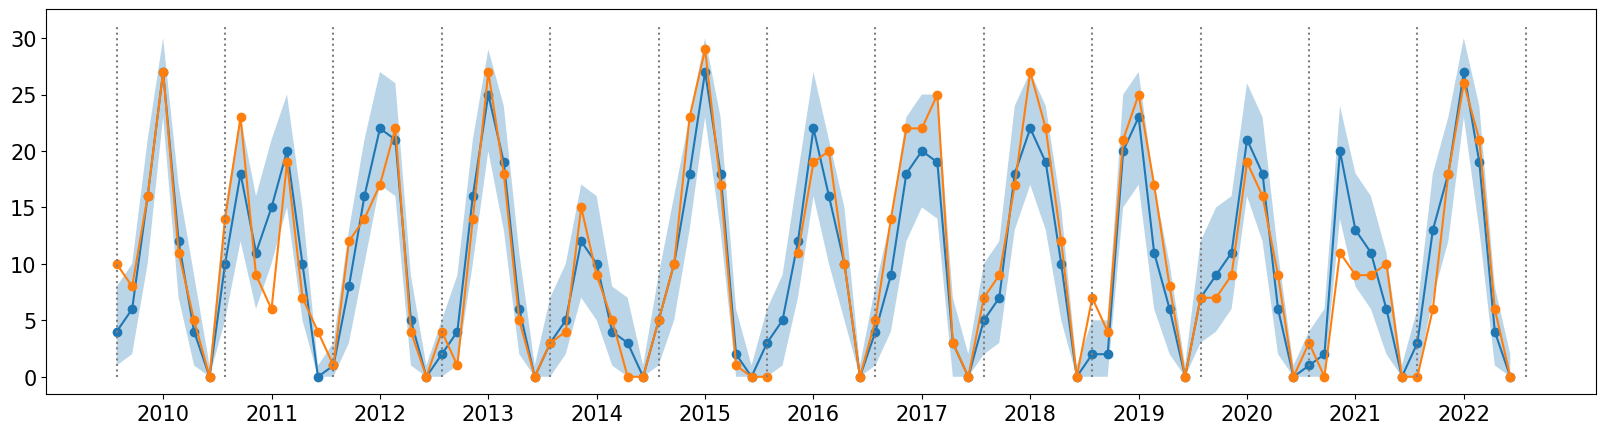

In [83]:
station_num_to_plot = 35 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(13*7*(station_num_to_plot-1), 13*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(20, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted', linestyle='-', marker='o')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed', linestyle='-', marker='o')
plt.xticks(xx[np.arange(3,len(xx),7)], np.arange(2010,2023), fontsize=15)
plt.yticks(fontsize=15)
plt.vlines(xx[np.arange(0,len(xx),7)], ymin=0, ymax=31, colors='gray', linestyles='dotted')
plt.vlines(xx[-1]+1, ymin=0, ymax=31, colors='gray', linestyles='dotted')
plt.savefig('sample_180.pdf')
plt.show()

# Confronto CI Beta

In [91]:
betas_180 = posterior_bin_logit_var_180.posterior['beta'].stack(sample=("chain", "draw"))
betas_120 = posterior_bin_logit_var_120.posterior['beta'].stack(sample=("chain", "draw"))

<xarray.DataArray 'beta' (beta_dim_0: 11, sample: 4000)>
array([[ 1.96162e+00,  1.91858e+00,  1.79774e+00, ...,  1.82723e+00,
         2.09174e+00,  1.81548e+00],
       [-1.21533e-02, -3.64319e-02,  1.47975e-03, ..., -2.75003e-02,
         3.77909e-02, -8.32019e-02],
       [-2.15458e-01, -1.23055e-01, -2.16199e-01, ..., -6.11337e-02,
        -2.00320e-01, -1.24396e-01],
       ...,
       [ 7.68394e-01,  3.54216e-01,  3.83331e-01, ...,  3.02246e-01,
         4.97318e-01,  9.24978e-01],
       [-1.88488e+00, -1.92682e+00, -1.68973e+00, ..., -8.18683e-01,
        -1.61126e+00, -1.65716e+00],
       [-1.24790e+00, -8.32427e-01, -1.02142e+00, ..., -1.17112e+00,
        -1.74892e+00, -1.55448e+00]])
Coordinates:
  * beta_dim_0  (beta_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10
  * sample      (sample) object MultiIndex
  * chain       (sample) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw        (sample) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

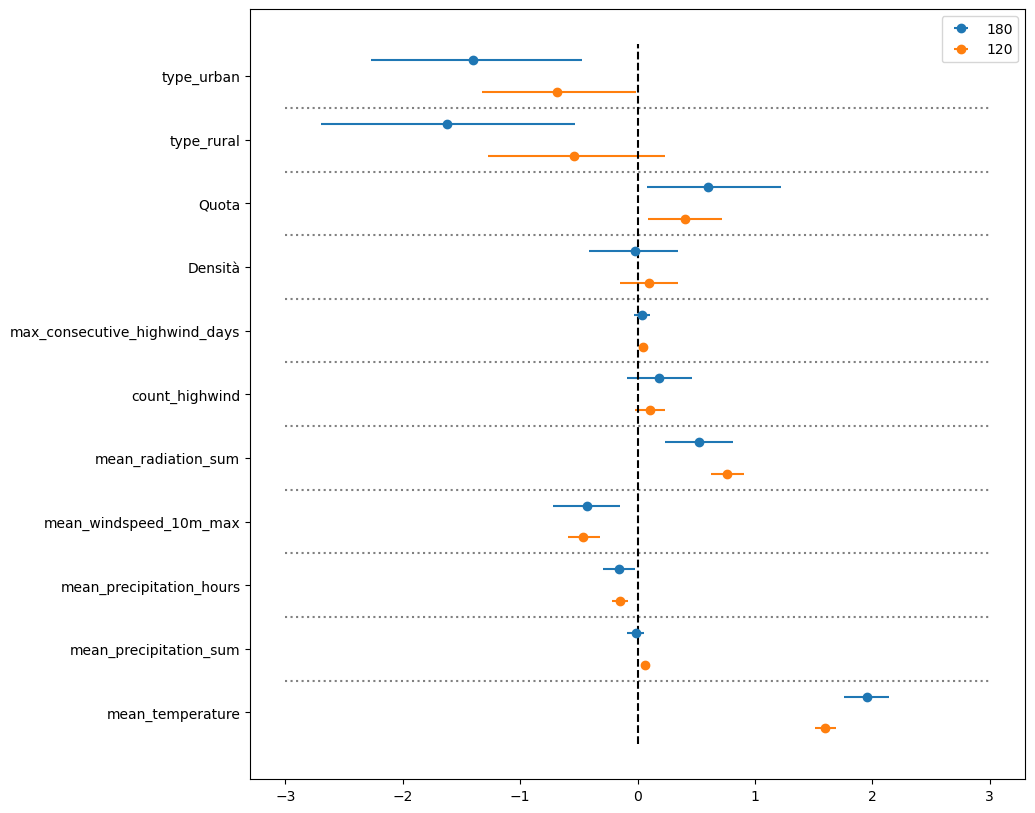

In [119]:
# Plot the CI for the coefficients horizontally
plt.figure(figsize=(10, 10))
plt.errorbar(betas_180.mean(dim='sample'), np.arange(2, len(X.columns)*4 +2, 4), xerr=[betas_180.mean(dim='sample') - betas_180.quantile(0.025, dim='sample'), betas_180.quantile(0.975, dim='sample') - betas_180.mean(dim='sample')], fmt='o', label='180')
plt.errorbar(betas_120.mean(dim='sample'), np.arange(0, len(X.columns)*4, 4), xerr=[betas_120.mean(dim='sample') - betas_120.quantile(0.025, dim='sample'), betas_120.quantile(0.975, dim='sample') - betas_120.mean(dim='sample')], fmt='o', label='120')
plt.yticks(np.arange(1, len(X.columns)*4 + 1, 4), X.columns)
plt.hlines(np.arange(3, len(X.columns)*4-1, 4), xmin=-3, xmax=3, colors='gray', linestyles='dotted')
plt.vlines(0, ymin=-1, ymax=len(X.columns)*4-1, colors='black', linestyles='--')
plt.legend()
plt.show()

